# Netflix Exploratory Data Analysis
## By: Zachary Delk

In [ ]:
# Loading and Inspecting
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# Downloading and Storing Dataset
working_path = kagglehub.dataset_download("shivamb/netflix-shows")
file_path = working_path + "/netflix_titles.csv"
df = pd.read_csv(file_path)

# Inspecting Data
print(df.head(3))
print(df.info())

/home/zdelk/workspace/github.com/zdelk/netflix_eda/venv_eda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  show_id     type                 title         director  \
0      s1    Movie  Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show         Blood & Water              NaN   
2      s3  TV Show             Ganglands  Julien Leclercq   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   

                

In [3]:
# Step 2: Data Cleaning

# Dealing with missing data
df[df == 'Not Given'] = np.nan

# Removing Uneccessary Keywords in Genre
substring_to_remove = ['TV', 'Shows', 'Movies', '\'']
pattern = "|".join(substring_to_remove)
df['listed_in'] = df['listed_in'].str.replace(pattern, "", regex=True)

# Creating list columns for where there are multiple entries
to_split = ['director', 'cast', 'country', 'listed_in']

df_clean = df.copy()

for col in to_split:
    col_name = col + '_list'
    df_clean[col_name] = df[col].str.split(r',\s*', regex=True).apply(
        lambda x: [i.strip() for i in x] if isinstance(x, list) else None
        )


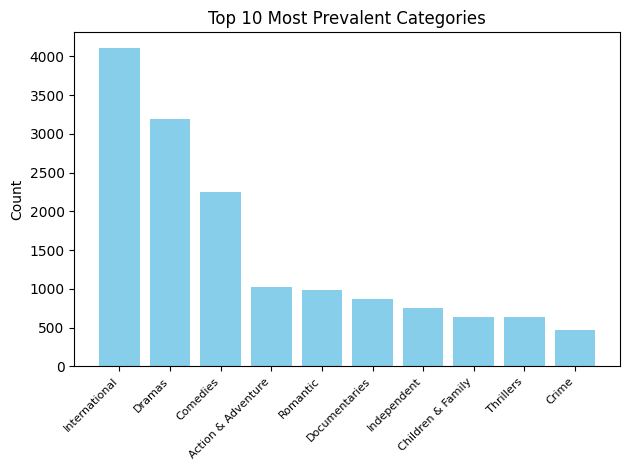

In [4]:
# Q1.What are the most prevalent categories?

# Using the column of lists to make a Category dictionary
cat_dict = {}
for show in df_clean['listed_in_list']:
    for cat in show:
        if cat in cat_dict:
            cat_dict[cat] += 1
        else:
            cat_dict[cat] = 1

# Sorting Dictionary and Looking at 10 Most Prevalent Categories
sorted_cats = sorted(cat_dict.items(), key=lambda item: item[1], reverse=True)
top_10_cats = sorted_cats[:10]
# print(top_10_cats)
categories, counts = zip(*top_10_cats)
plt.bar(x=categories, height=counts, color = 'skyblue')
plt.title('Top 10 Most Prevalent Categories')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.tight_layout()

4306


<Axes: ylabel='Total'>

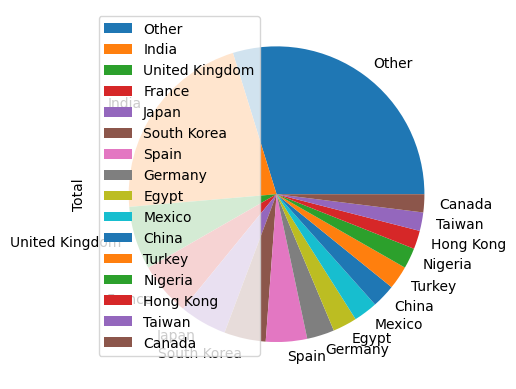

In [5]:
# Looking Deeper into it

# Subset data to just relevant info
# Only worried about entries where 'International' is in the categories
subset_int = df_clean[['country_list', 'listed_in_list', 'type']].dropna()
subset_int = subset_int[subset_int['listed_in_list'].apply(lambda x: 'International' in x)]


# Each country for each observation gets its own row
exploded = subset_int.explode('country_list')

# Getting Counts of Tv Shows and Movies for each country
country_media_df = exploded.groupby(['country_list','type'], observed=True).size().unstack(fill_value=0)

country_media_df['Total'] = country_media_df.sum(axis=1) # Total media for country
cm_sorted = country_media_df.sort_values(by='Total', axis=0, ascending=False) # Sorting by total count

# Dropping US since I live there
cm_sorted = cm_sorted.drop('United States')

ten_place = cm_sorted['Total'].iloc[14] # Count for 10th largest
print(cm_sorted['Total'].sum())
cm_sorted = cm_sorted.reset_index()
# If below rank 10 grouped to Other
cm_sorted['country_list'] = cm_sorted['country_list'].where(cm_sorted['Total'] >= ten_place, 'Other')

cm_grouped = (
    cm_sorted
    .groupby('country_list')[['Movie', 'TV Show', 'Total']]
    .sum()
    .sort_values(by='Total', ascending=False)
)


cm_grouped.plot.pie(y='Total')

In [6]:
# - Who is/are the most prolific directors for each country?
mask = df_clean['director_list'].notna() & df_clean['country_list'].notna()
directors = df_clean.loc[mask, ['director_list','country_list']]
directors_exploded = directors.explode('director_list').explode('country_list')
director_count = (
    directors_exploded
    .groupby(['director_list','country_list'])
    .size()
    .reset_index(name='count')
)

most_prolific = (
    director_count
    .sort_values('count', ascending=False)
    .groupby('country_list')
    .head(1)
    .reset_index(drop=True)
)
print(most_prolific)
# top_10_dir.plot.bar(color='lightgreen')
# plt.title('Most Prolific Directors')
# plt.ylabel('Count')
# plt.xticks(rotation=45, ha='right', fontsize = 8)
# plt.tight_layout()

           director_list   country_list  count
0           Marcus Raboy  United States     15
1    Cathy Garcia-Molina    Philippines     13
2              Jan Suter         Mexico     12
3        Youssef Chahine          Egypt     12
4         Yılmaz Erdoğan         Turkey      9
..                   ...            ...    ...
113        Saara Cantell         Latvia      1
114        Sarah Moshman          Samoa      1
115        Storm Saulter        Jamaica      1
116         Tiffanie Hsu         Uganda      1
117          Wim Wenders   Vatican City      1

[118 rows x 3 columns]


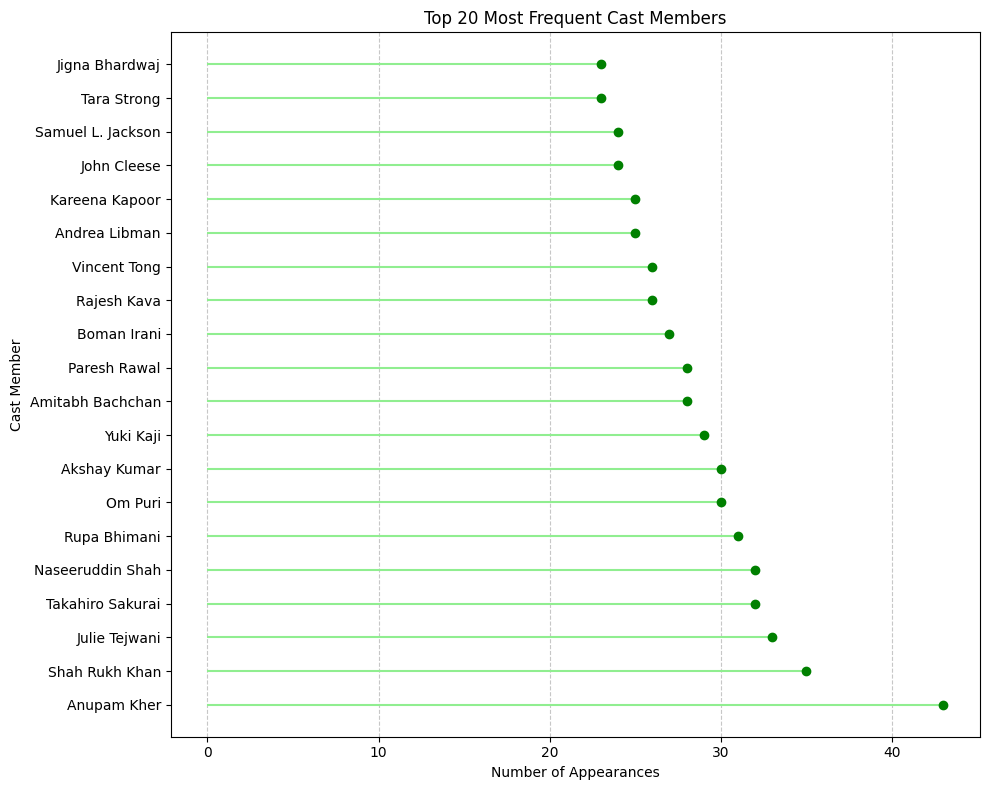

In [13]:
# - Most common cast member?

subset_cast = df_clean['cast_list'].dropna()

cast_exploded = subset_cast.explode('cast_list')
cast_count = cast_exploded.value_counts().reset_index()

top_n = 20
top_cast = cast_count.head(top_n)

plt.figure(figsize=(10,8))
plt.hlines(y=top_cast['cast_list'], xmin=0, xmax=top_cast['count'], color='lightgreen')
plt.plot(top_cast['count'], top_cast['cast_list'], 'o', color='green')

plt.xlabel('Number of Appearances')
plt.ylabel('Cast Member')
plt.title(f'Top {top_n} Most Frequent Cast Members')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

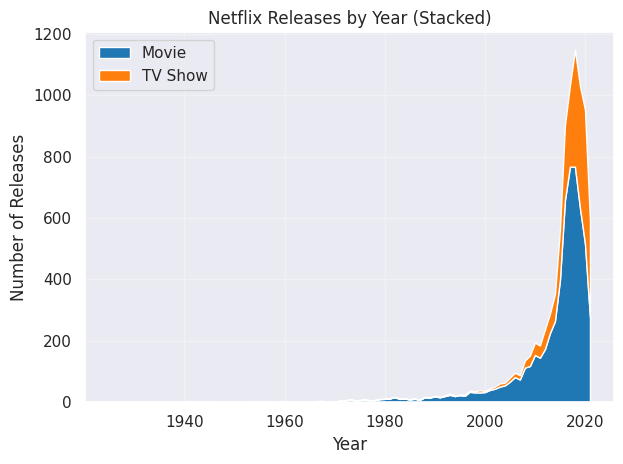

In [ ]:
import seaborn as sns

sns.set_theme()
# - Amount of releases by year split by TV Show or Movie
subset_time = df[['type','release_year']].dropna()
release_group = subset_time.groupby(['release_year','type']).size().unstack(fill_value = 0)
release_group_counts = release_group.sort_index()

plt.stackplot(release_group_counts.index,
              release_group_counts['Movie'],
              release_group_counts['TV Show'],
              labels=['Movie', 'TV Show'],
              colors=['#1f77b4', '#ff7f0e']
              )

plt.legend(loc='upper left')
plt.title('Netflix Releases by Year (Stacked)')
plt.xlabel('Year')
plt.ylabel('Number of Releases')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
# - How long are the movies on average, by genre or by country?
df_movie = df[df['type'] == 'Movie']
df_movie['duration'] = df_movie['duration'].str.replace('min', "")
df_movie['duration_int'] = df_movie['duration'].astype('Int64')


/tmp/ipykernel_17273/2263589336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie['duration'] = df_movie['duration'].str.replace('min', "")
/tmp/ipykernel_17273/2263589336.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie['duration_int'] = df_movie['duration'].astype('Int64')
